In [25]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion

import emcee

%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

        PCa_b      Tref    perm50  CV_ventricles  a_ventricles   EDP_lv  \
0    0.000104  181.8800  0.432887       0.541089       1.47935  7.13285   
1    0.000093  117.2970  0.299218       0.435956       3.51870  4.36058   
2    0.000037   78.5908  0.318741       0.489729       3.26294  7.29318   
3    0.000068  204.1080  0.280034       0.564459       3.48290  5.81285   
4    0.000057  192.8150  0.303769       0.792342       2.23830  2.85869   
..        ...       ...       ...            ...           ...      ...   
995  0.000101  143.8110  0.200636       0.687560       3.18245  2.06155   
996  0.000128   93.3145  0.187213       0.655885       2.91642  1.75915   
997  0.000073   72.4349  0.509966       0.474934       1.80298  3.93620   
998  0.000145   79.0890  0.315106       0.396598       1.00549  7.17315   
999  0.000128  155.7950  0.484251       0.614842       1.89202  3.18508   

      EDP_rv     Rsys    Rpulm  
0    3.79291  2.75361  3.56667  
1    1.39339  2.78153  3.51396  


In [27]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

In [28]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_6/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   154.92   6.49  126.15   66.53        956       -487  179.10   2.40   
1   173.98   7.32  154.84   47.91        638       -324  162.16   2.86   
2   172.41   7.04  165.67   19.40        193        -97  180.76   4.16   
3   165.73   7.35  143.18   67.00        912       -486  147.22   2.70   
4   169.99   8.09  155.98   52.72        721       -352  142.09   2.84   
5   153.92   5.97  128.15   69.19       1134       -505  178.36   2.04   
6   170.19   6.93  164.48   34.62        402       -214  154.32   3.42   
7   169.46  10.56  150.17   61.69        741       -399  155.75   2.46   
8   164.23   8.46  148.00   31.88        400       -206  165.12   3.98   
9   164.82   7.16  116.26   69.36       1224       -596  150.67   3.60   
10  173.65   7.30  152.36   60.73        719       -335  153.10   2.35   
11  161.08   8.29  154.38   29.50        266       -152  165.05   3.90   
12  166.16   7.00  135.89   69.35     

In [29]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

In [30]:
input_masked=input_masked.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [31]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[4.30915e-05, 0.000141663]
[60.0088, 213.146]
[0.193135, 0.518036]
[0.411063, 0.796491]
[1.50272, 4.95594]
[1.03757, 7.40647]
[1.03544, 7.09553]
[1.16178, 3.93971]
[1.01728, 3.95163]


In [32]:
y_calibration = y_all.loc[:,['V_TAT','LVpMax']]

y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

y_calibration=y_calibration.join(y_calibration2)

In [33]:
y_train = torch.tensor(y_calibration.values)
x_train = torch.tensor(input_masked.values)

In [34]:
new_labels = x_labels.values
for i,l in enumerate(new_labels):
    new_labels[i] = str(l)+"_one_over"

In [35]:
new_X_one_over = 1/input_masked
new_X_one_over.columns = new_labels[0:15]
new_X_one_over

(['PCa_b']_one_over,)  (['Tref']_one_over,)  (['perm50']_one_over,)  \
0            10801.959043              0.008525                3.342045   
1            17571.604287              0.005186                3.291975   
2            20103.896939              0.005714                2.317610   
3            12239.123091              0.006829                3.451394   
4            16139.627142              0.004895                2.755246   
5             7386.451770              0.010317                2.007274   
6            15750.809592              0.005214                2.352078   
7            14552.715027              0.006800                3.558668   
8            11156.854213              0.015345                1.930368   
9             7059.006233              0.008231                3.195511   
10           11331.637365              0.014704                3.805247   
11           23206.432823              0.005248                4.480146   
12           10226.967080              0.005823                2.157837   
13            9810.943126              0.005120                1.955757   
14           14064.796518              0.005211                2.455494   
15           13740.397180              0.011356                3.895917   
16           14783.495705              0.004874                2.601234   
17           14266.841293              0.004692                3.231498   
18           11434.255887              0.007948                4.324829   
19            7177.874918              0.006391                2.198590   
20           22695.602046              0.014425                2.005033   
21            7495.071990              0.008073                2.314772   
22           20317.398398              0.010038                4.832716   
23           15328.019620              0.005587                3.736977   
24           12205.332754              0.005852                2.705716   
25           15830.875590              0.006891                5.177725   
26           11957.102698              0.005180                3.489110   
27           12584.362420              0.016664                3.741171   
28           11042.732060              0.006066                2.260040   
29            9390.112212              0.009419                3.310195   
30            7120.985544              0.011134                2.017618   
31            7419.498442              0.005748                2.446429   
32            7277.172964              0.014073                2.527857   
33           15414.923496              0.007532                3.165188   
34           15389.563721              0.005990                2.859684   
35           11922.276296              0.006527                4.054312   
36           16006.633149              0.006365                2.297699   
37            9332.885355              0.006879                2.452489   

    (['CV_ventricles']_one_over,)  (['a_ventricles']_one_over,)  \
0                        2.293809                      0.284196   
1                        1.262081                      0.446768   
2                        1.713103                      0.333192   
3                        1.330670                      0.213760   
4                        1.358585                      0.386716   
5                        1.444769                      0.535146   
6                        2.432717                      0.248848   
7                        1.935262                      0.212081   
8                        1.405985                      0.201778   
9                        1.466220                      0.215246   
10                       1.954377                      0.631313   
11                       1.307073                      0.286844   
12                       1.944322                      0.238138   
13                       1.310783                      0.202394   
14                       1.938537                      0.217825   
15    

In [36]:
new_X_adjust=pd.concat([input_masked,new_X_one_over],axis=1)

In [37]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_calibration 
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=seed
)

In [38]:
new_X_one_over = 1/X_n_train
new_X_one_over.columns = new_labels[0:15]
new_X_one_over

new_X_one_over_test = 1/X_n_test
new_X_one_over_test.columns = new_labels[0:15]
new_X_one_over_test

(['PCa_b']_one_over,)  (['Tref']_one_over,)  (['perm50']_one_over,)  \
9             7059.006233              0.008231                3.195511   
1            17571.604287              0.005186                3.291975   
21            7495.071990              0.008073                2.314772   
2            20103.896939              0.005714                2.317610   

    (['CV_ventricles']_one_over,)  (['a_ventricles']_one_over,)  \
9                        1.466220                      0.215246   
1                        1.262081                      0.446768   
21                       1.843889                      0.263448   
2                        1.713103                      0.333192   

    (['EDP_lv']_one_over,)  (['EDP_rv']_one_over,)  (['Rsys']_one_over,)  \
9                 0.370364                0.140934              0.689493   
1                 0.349811                0.323374              0.389797   
21                0.204557                0.450331              0.856825   
2                 0.957974                0.537730              0.703715   

    (['Rpulm']_one_over,)  
9                0.641511  
1                0.592565  
21               0.357573  
2                0.407402

In [39]:
X_over_train=pd.concat([X_n_train,new_X_one_over],axis=1)
X_over_test =pd.concat([X_n_test,new_X_one_over_test],axis=1)
X_over_train.columns = X_over_train.columns.astype(str)
X_over_test.columns = X_over_test.columns.astype(str)

In [40]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score


model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=True)),
    ('lasso', MultiTaskLassoCV(n_alphas=100,max_iter=1000))
])

# fit to an order-3 polynomial data
model = model.fit(X_over_train, y_n_train)
lasso_coef=model.named_steps['lasso'].coef_

In [41]:
r2_score(y_n_test,model.predict(X_over_test))

0.9655723871005663

In [42]:
y_n_test

V_TAT  LVpMax     LV_EF
9    98.627   69.36  0.294624
1    85.098   47.91  0.110013
21  123.965   60.12  0.304803
2   115.609   19.40  0.039093

In [43]:
np.max(lasso_coef,axis=0)

array([ 0.00000000e+00,  9.15978432e-01, -2.14597500e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.44972360e+00,
       -4.62483629e-03, -6.69117757e-02,  4.12516452e-03,  4.20923536e+00,
        2.48877885e+01,  1.47690644e+00,  1.77240668e-01,  2.46710968e+00,
        0.00000000e+00,  1.37086087e+00])

In [44]:
X_over_test.columns

Index(['PCa_b', 'Tref', 'perm50', 'CV_ventricles', 'a_ventricles', 'EDP_lv',
       'EDP_rv', 'Rsys', 'Rpulm', '("['PCa_b']_one_over",)',
       '("['Tref']_one_over",)', '("['perm50']_one_over",)',
       '("['CV_ventricles']_one_over",)', '("['a_ventricles']_one_over",)',
       '("['EDP_lv']_one_over",)', '("['EDP_rv']_one_over",)',
       '("['Rsys']_one_over",)', '("['Rpulm']_one_over",)'],
      dtype='object')

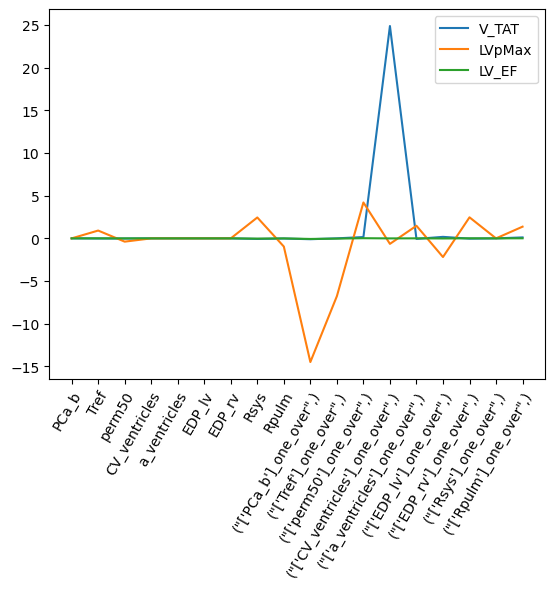

In [45]:
fig, ax = plt.subplots()
plt.plot(X_over_test.columns,(lasso_coef).T)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.legend(y.columns)

In [46]:
1-((y_n_test-model.predict(X_over_test))**2).mean()/np.var(y_n_test)

V_TAT     0.998183
LVpMax    0.920929
LV_EF     0.977605
dtype: float64

In [47]:


model = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', MultiTaskLassoCV(n_alphas=100,max_iter=10000))
])
# fit to an order-3 polynomial data
model = model.fit(X_over_train, y_n_train)
lasso_coef=model.named_steps['lasso'].coef_

In [48]:
np.max(lasso_coef,axis=0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.41968529e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.17147830e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.21710368e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.77558504e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.42460414e+00,  0.00000000e+00,  1.27223126e+00,  0.00000000e+00,
        0.00000000e+00,  

Text(0.5, 0, 'Polynomial inputs')

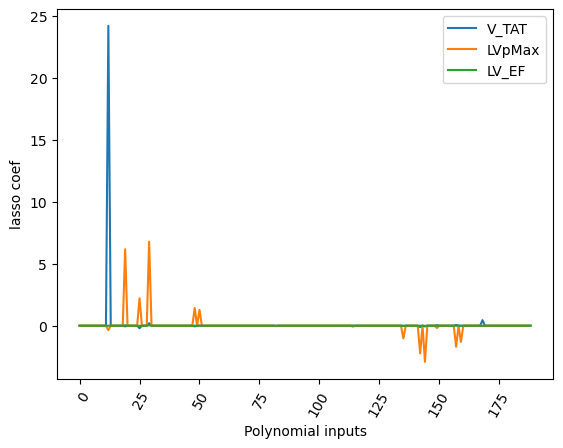

In [49]:
fig, ax = plt.subplots()
plt.plot((lasso_coef).T)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.legend(y.columns)
plt.ylabel('lasso coef')
plt.xlabel('Polynomial inputs')

In [50]:
r2_score(y_n_test,model.predict(X_over_test))

0.9188363093053086

In [51]:
1-((y_n_test-model.predict(X_over_test))**2).mean()/np.var(y_n_test)

V_TAT     0.996480
LVpMax    0.817744
LV_EF     0.942285
dtype: float64

In [52]:
y_shift_train = torch.tensor((y_n_train-model.predict(X_over_train)).values)
x_shift_train = torch.tensor(X_n_train.values)

y_shift_test=torch.tensor((y_n_test-model.predict(X_over_test)).values)
x_shift_test =torch.tensor(X_n_test.values)

In [55]:
emulator = GPE.ensemble(x_shift_train,y_shift_train,training_iter=1000,mean_func='zero',structure_index=[[0],[1],[2]])

0
1
2


In [56]:
emulator.R2(x_shift_test,y_shift_test)

tensor([ 0.8796, -0.1298, -0.2953], dtype=torch.float64,
       grad_fn=<RsubBackward1>)

In [57]:
1-(y_n_test-(emulator.predict(x_shift_test).detach().numpy()+model.predict(X_over_test))).mean()**2/np.var(y_n_test)

V_TAT     0.999970
LVpMax    0.969782
LV_EF     0.982141
dtype: float64

In [58]:
X_n_train

PCa_b      Tref    perm50  CV_ventricles  a_ventricles   EDP_lv  \
13  0.000102  195.3290  0.511311       0.762903       4.94087  2.45167   
18  0.000087  125.8230  0.231223       0.675445       2.81211  2.09770   
17  0.000070  213.1460  0.309454       0.539625       2.89782  2.40825   
20  0.000044   69.3245  0.498745       0.566649       3.50267  7.40647   
15  0.000073   88.0595  0.256679       0.411125       3.76311  4.69538   
26  0.000084  193.0390  0.286606       0.536503       1.77238  3.20352   
24  0.000082  170.8920  0.369588       0.626029       4.25636  5.48501   
5   0.000135   96.9297  0.498188       0.692152       1.86865  5.03361   
35  0.000084  153.2060  0.246651       0.420667       1.67018  3.71659   
22  0.000049   99.6221  0.206923       0.506853       2.36287  3.55738   
27  0.000079   60.0088  0.267296       0.682532       3.81909  1.93903   
34  0.000065  166.9310  0.349689       0.796491       3.97376  4.00935   
11  0.000043  190.5500  0.223207       0.765068       3.48622  4.53282   
0   0.000093  117.2970  0.299218       0.435956       3.51870  4.36058   
12  0.000098  171.7450  0.463427       0.514318       4.19925  1.42490   
29  0.000106  106.1680  0.302097       0.536890       4.62568  4.46878   
16  0.000068  205.1670  0.384433       0.430086       4.30373  2.89618   
37  0.000107  145.3620  0.407749       0.512005       4.08403  4.40167   
6   0.000063  191.7800  0.425156       0.411063       4.01851  1.24429   
7   0.000069  147.0590  0.281004       0.516726       4.71517  4.19987   
32  0.000137   71.0601  0.395592       0.571907       1.75746  3.62239   
10  0.000088   68.0077  0.262795       0.511672       1.58400  4.16624   
30  0.000140   89.8158  0.495634       0.450332       1.66620  2.90414   
31  0.000135  173.9840  0.408759       0.691569       3.13226  5.99124   
8   0.000090   65.1695  0.518036       0.711245       4.95594  3.27544   
33  0.000065  132.7710  0.315937       0.599925       1.71623  1.16011   
14  0.000071  191.8870  0.407250       0.515853       4.59084  2.84637   
36  0.000062  157.1000  0.435218       0.744041       1.50272  1.56949   
28  0.000091  164.8530  0.442470       0.773581       1.90451  3.60427   
23  0.000065  178.9770  0.267596       0.760395       3.04220  2.23222   
19  0.000139  156.4670  0.454837       0.605170       1.98887  5.67945   
3   0.000082  146.4240  0.289738       0.751501       4.67815  2.75242   
25  0.000063  145.1240  0.193135       0.416262       2.20496  1.03757   
4   0.000062  204.2960  0.362944       0.736060       2.58588  4.82903   

     EDP_rv     Rsys    Rpulm  
13  6.12943  2.27825  1.44852  
18  1.94747  2.03456  3.34978  
17  4.94400  2.91807  3.59880  
20  1.15053  1.20911  1.05503  
15  4.08651  1.40196  1.20405  
26  5.54725  1.29843  1.01728  
24  1.03544  3.49951  2.77824  
5   1.61164  3.02116  3.95163  
35  2.51360  2.58739  1.80530  
22  6.27996  2.13917  3.21177  
27  2.57271  2.81816  3.27431  
34  3.85973  2.21709  3.18628  
11  4.46832  2.43623  3.23700  
0   1.39339  2.78153  3.51396  
12  1.25617  2.73199  2.86147  
29  1.44076  3.04924  3.00458  
16  4.63947  3.36622  3.12087  
37  2.91837  1.78072  2.29624  
6   5.41391  2.98988  3.57288  
7   4.78627  3.93971  1.14365  
32  1.86713  2.29810  1.76089  
10  3.59433  3.62845  2.36502  
30  2.68600  1.67022  2.02054  
31  2.46260  1.16178  1.86024  
8   4.65155  1.64056  1.75648  
33  4.72253  3.61412  3.36761  
14  4.96016  2.97278  3.79852  
36  3.95761  1.91220  1.91333  
28  4.76667  2.90747  3.06228  
23  4.05255  3.14645  2.19518  
19  2.36571  1.66676  3.60422  
3   6.89489  3.77755  3.49490  
25  2.09894  1.51794  1.03907  
4   6.33496  3.91539  2.63424

In [43]:
x_e_train=torch.tensor(X_n_train.values)
x_e_test=torch.tensor(X_n_test.values)
y_e_train=torch.tensor(y_n_train.values)
y_e_test=torch.tensor(y_n_test.values)

In [44]:
emulator_comp = GPE.ensemble(x_e_train,y_e_train,training_iter=1000,mean_func='linear')

0
1
2


In [48]:
emulator_comp.R2(x_e_test,y_e_test)

tensor([0.9995, 0.9913, 0.9907], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [49]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [50]:
y_calibration.shape

(38, 3)

In [51]:
def log_likelihood(x,emulator,lasso,y_val,sigma2):
    nMod=y_val.shape[1]
    x=torch.tensor(x)[None]
    x2=torch.cat([x,1/x],axis=1)
    l_mean = torch.tensor(lasso.predict(x2))
    ll =0
    models=emulator.models
    likelihoods=emulator.likelihoods
    inputNorm,outputNorm = emulator.normalise_test_data(x,y_val)
    inputNorm=inputNorm.float()
    outputNorm=outputNorm.float()
    for i in range(nMod):
            models[i].eval()
            likelihoods[i].eval()
            sigma = sigma2[i]
            k = likelihoods[i](models[i](inputNorm)).covariance_matrix.diag()
            mean=l_mean[:,i]
            variance = (emulator.training_output_STD[i]**2)*k+sigma
            
            likelihood_manual=emulator.gaussian_ll(y_val[:,i],mean,variance)
            
            #likelihood_manual=-0.5*((outputVal[:,i]-(self.training_output_STD[i]*m+self.training_output_mean[i]))**2)/((self.training_output_STD[i]**2)*k+sigma) -0.5*torch.log((self.training_output_STD[i]**2)*k+sigma) - 0.5*torch.log(torch.tensor(2*torch.pi))
            ll+= likelihood_manual
    
    
    return ll

In [52]:
def log_prob(theta, emulator,lasso,y_val,sigma2):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return (lp + log_likelihood(theta,emulator,lasso,y_val,sigma2)).detach().numpy()

In [53]:
y_train = torch.tensor(y_calibration.values)
x_train = torch.tensor(input_masked.values)

In [54]:
y_max=y_train.max(axis=0)

In [55]:
y_max

torch.return_types.max(
values=tensor([164.0110,  87.7000,   0.3968], dtype=torch.float64),
indices=tensor([15, 35, 31]))

In [56]:
y_test = y_train[y_max[1][2],:]
x_test = x_train[y_max[1][2],:]

y_train = y_train[~torch.all(y_train == y_test, dim=1)]
x_train = x_train[~torch.all(x_train == x_test, dim=1)]
x_lasso_train=torch.cat([x_train,1/x_train],axis=1)

In [57]:
lasso_model = model.fit(x_lasso_train, y_train)

In [58]:
y_shift_train=y_train-torch.tensor(lasso_model.predict(x_lasso_train))

In [59]:
emulator=GPE.ensemble(x_train,y_shift_train,training_iter=1000,mean_func='zero')

0
1
2


In [60]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test[None]
obs_error=torch.tensor([0.1,0.1,0.1])

In [61]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,lasso_model,y_val,obs_error])

In [62]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,lasso_model,y_val,obs_error))

[-361.79772529]
[-208.333422]
[-97.61836575]
[-4.57094459]
[-3664.45843979]
[-5337.64936575]
[-49.27075754]
[-398.3912699]
[-15006.86349427]
[-1026.38142457]
[-255.59770454]
[-362.43849715]
[-16.48725717]
[-585.07914228]
[-353.70788779]
[-8113.37376697]
[-10995.28105395]
[-11178.81567485]


In [63]:
sampler.run_mcmc(p0, 40000)

State([[1.15581125e-04 9.12179562e+01 2.53412340e-01 6.97424906e-01
  2.29047043e+00 5.20315629e+00 2.53177446e+00 3.21253137e+00
  2.21233912e+00]
 [1.20617432e-04 1.68502576e+02 4.59249787e-01 6.97797127e-01
  3.62348042e+00 4.36239667e+00 5.61487527e+00 2.43119573e+00
  1.44522383e+00]
 [1.28403713e-04 1.36372990e+02 4.97766484e-01 6.96191770e-01
  3.20315928e+00 2.59161814e+00 3.91624341e+00 2.69127135e+00
  2.04642515e+00]
 [1.00278181e-04 1.81415117e+02 2.65698141e-01 6.97590200e-01
  3.67874753e+00 7.18976844e+00 6.09527320e+00 1.69740135e+00
  1.86416653e+00]
 [1.02019883e-04 2.05523139e+02 4.24374763e-01 6.89307762e-01
  3.72684494e+00 1.12995192e+00 5.91104779e+00 3.06380605e+00
  1.30278744e+00]
 [1.17378585e-04 1.51551184e+02 3.97847648e-01 7.01160950e-01
  3.13056121e+00 2.58290895e+00 1.76733628e+00 2.97769260e+00
  3.65530590e+00]
 [1.40494301e-04 1.27684579e+02 2.90617929e-01 6.97322736e-01
  2.28227160e+00 4.27073664e+00 1.74376985e+00 1.26457511e+00
  3.32489770e+00]


(54000, 9)


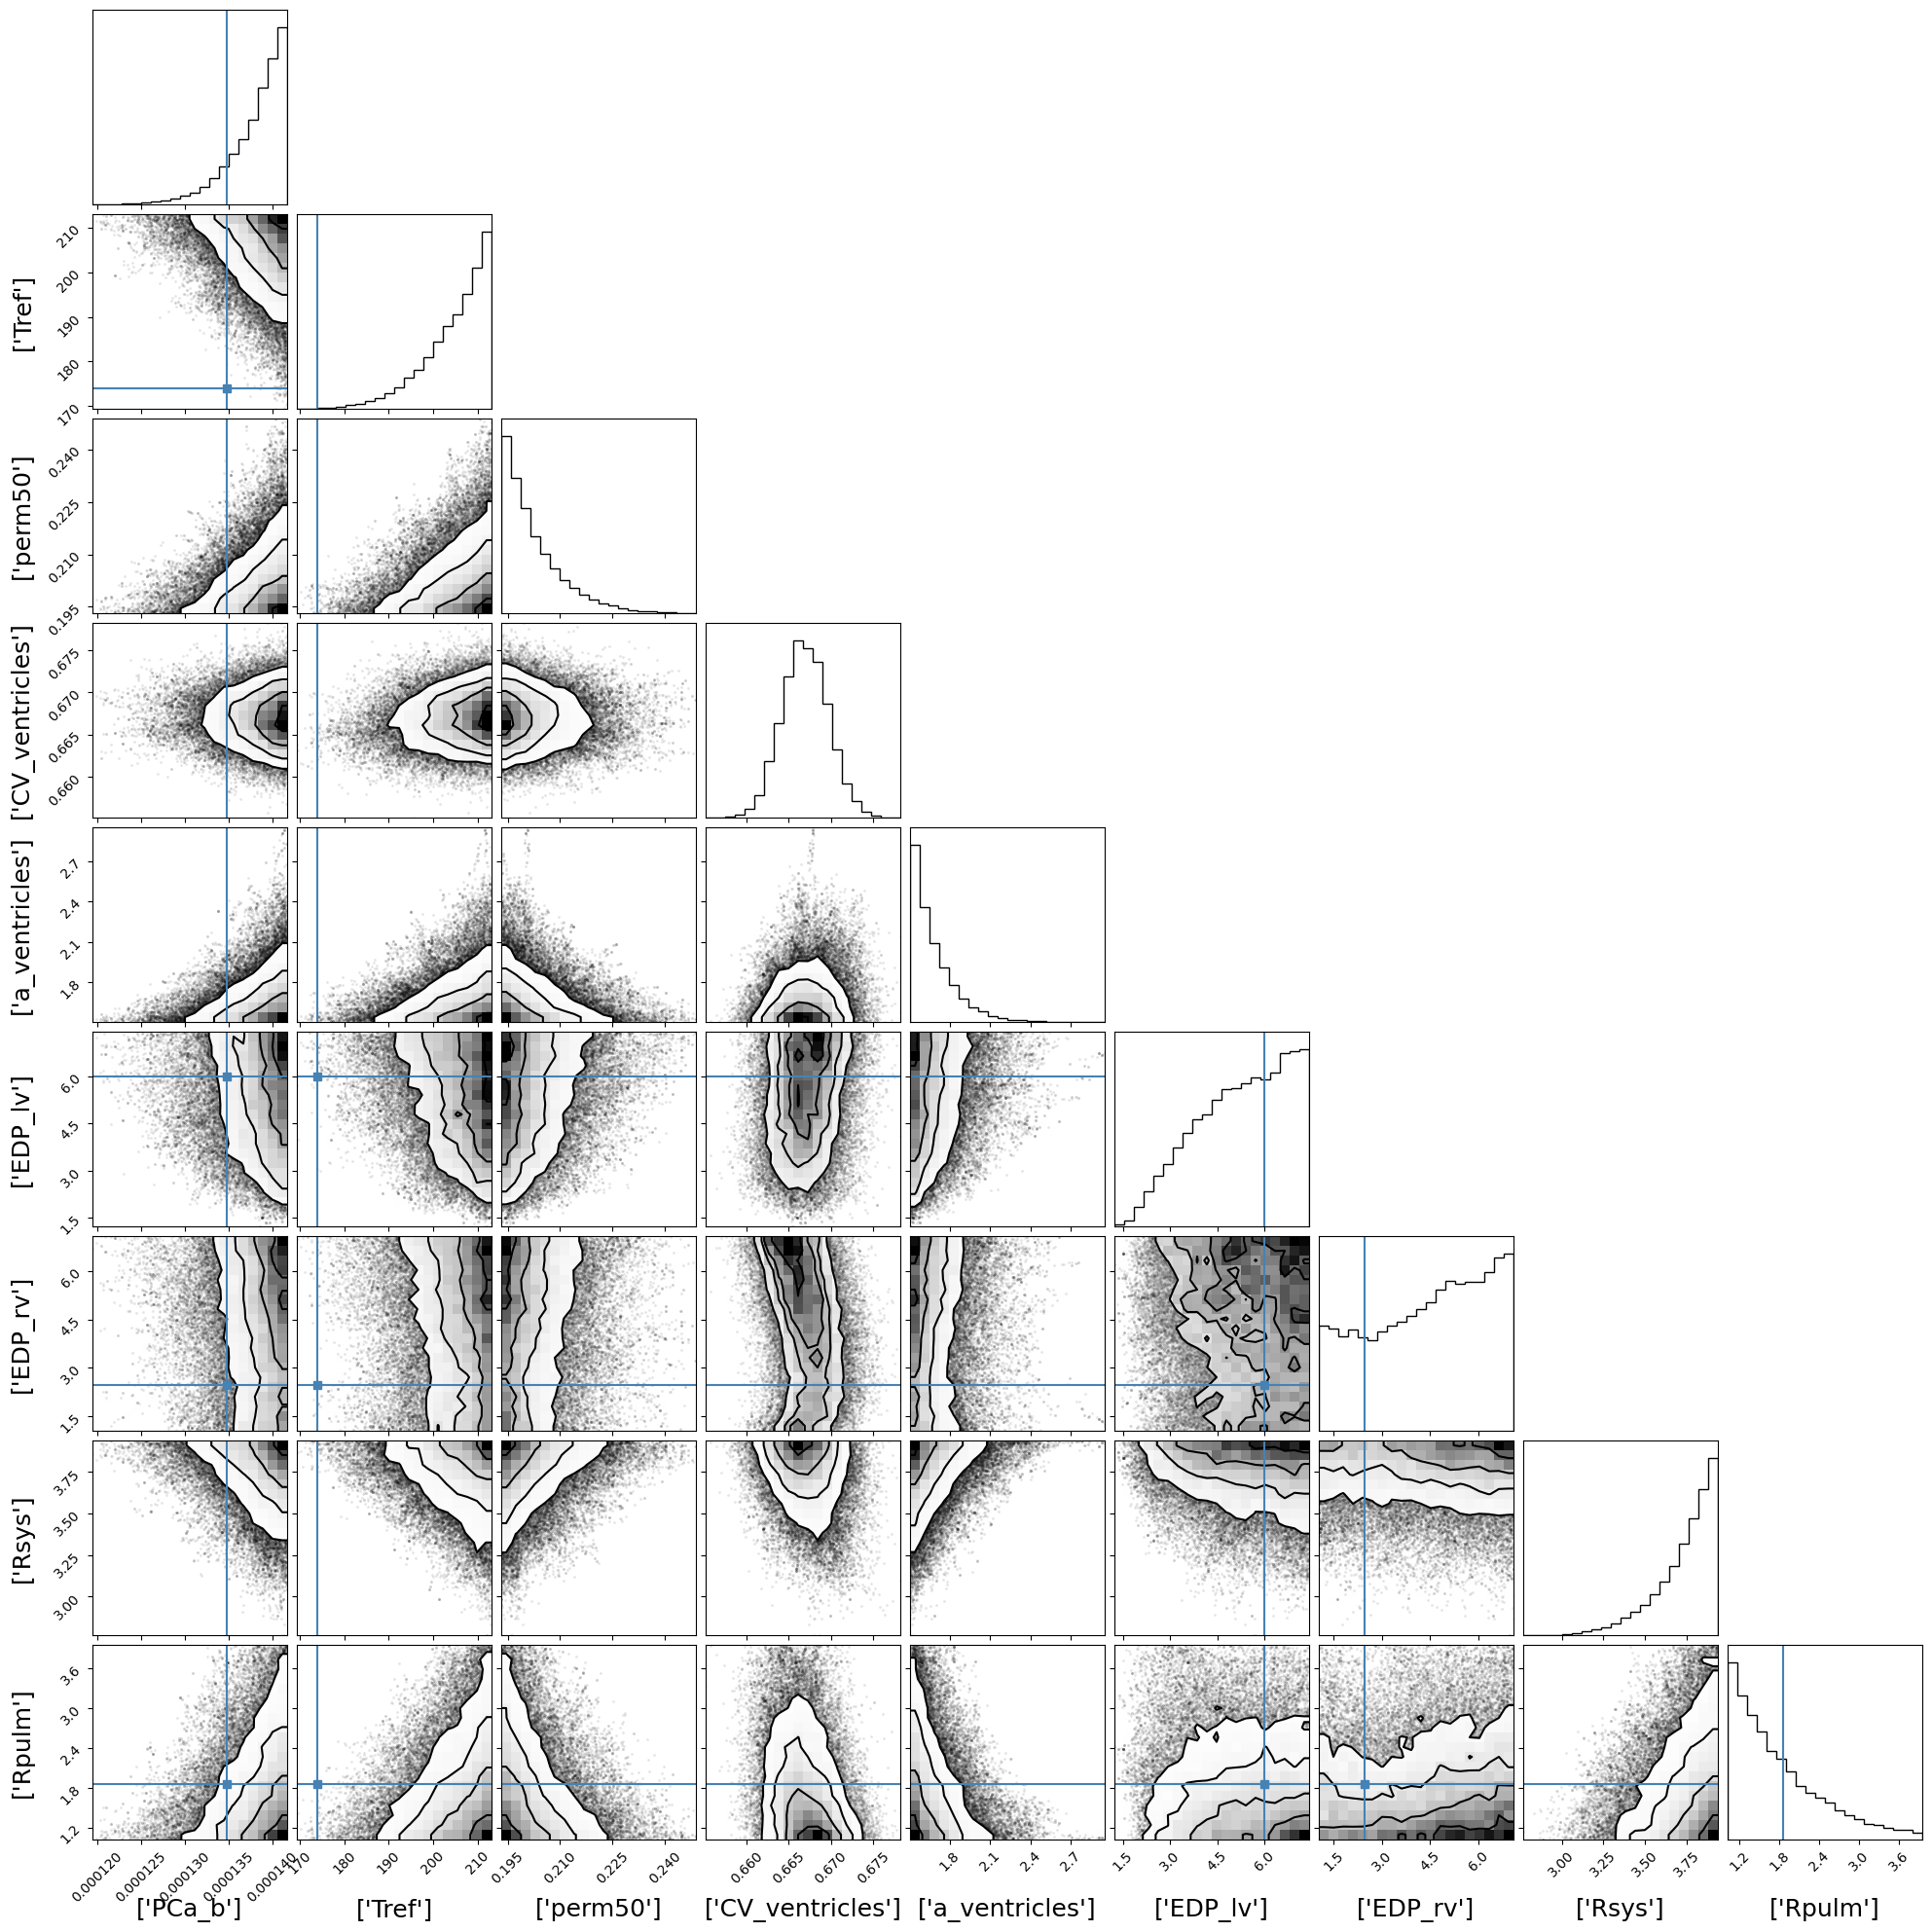

In [87]:
flat_samples = sampler.get_chain(discard=10000, thin=10, flat=True)
print(flat_samples.shape)

x_test

import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values,truths=x_test, label_kwargs=dict(fontsize=18)
);

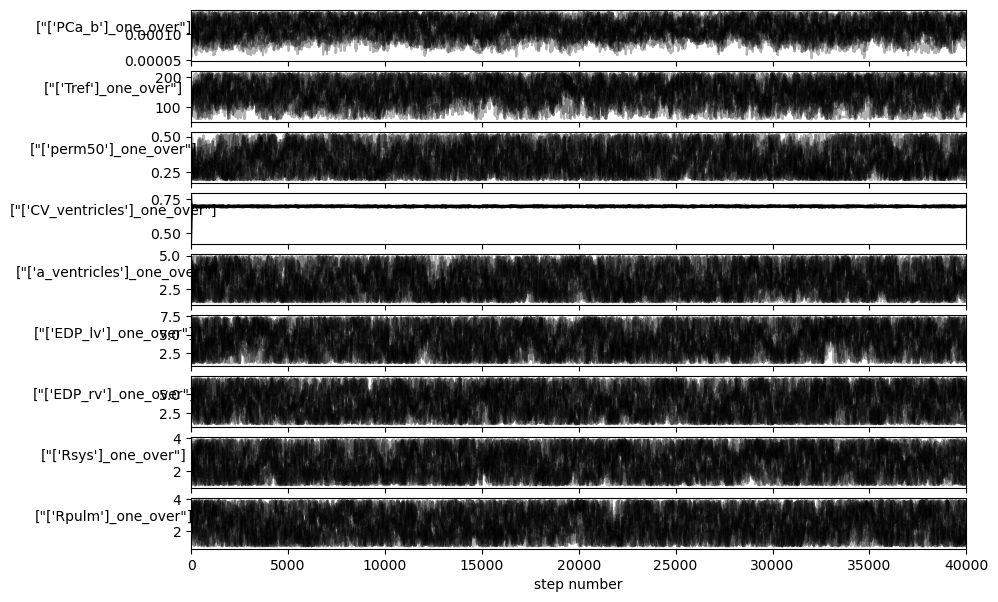

In [65]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [66]:
prediction=emulator.predict(torch.tensor(flat_samples)).detach().numpy()+lasso_model.predict(torch.cat([torch.tensor(flat_samples),torch.tensor(1/flat_samples)],axis=1))

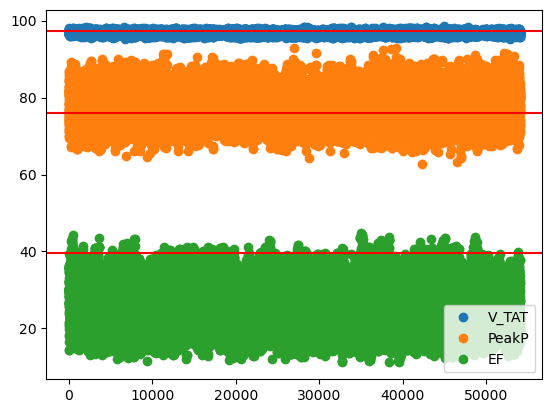

In [67]:
plt.plot(prediction[:,0:2],'o')
plt.plot(prediction[:,2]*100,'o')
plt.legend(('V_TAT','PeakP','EF'),loc='lower right')
plt.axhline(y=y_test[0], color='r', linestyle='-')
plt.axhline(y=y_test[1], color='r', linestyle='-')
plt.axhline(y=y_test[2]*100, color='r', linestyle='-')

In [68]:
y_train = torch.tensor(y_calibration.values)
x_train = torch.tensor(input_masked.values)

x_lasso_train=torch.cat([x_train,1/x_train],axis=1)

In [69]:
y_max=y_train.max(axis=0)

In [70]:
y_max

torch.return_types.max(
values=tensor([164.0110,  87.7000,   0.3968], dtype=torch.float64),
indices=tensor([15, 35, 31]))

In [71]:
y_test = torch.tensor([100,157,0.6])

In [72]:
lasso_model = model.fit(x_lasso_train, y_train)

In [73]:
y_shift_train=y_train-torch.tensor(lasso_model.predict(x_lasso_train))

In [74]:
emulator=GPE.ensemble(x_train,y_shift_train,training_iter=1000,mean_func='zero')

0
1
2


In [76]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test[None]
obs_error=torch.tensor([0.1,0.1,0.1])

In [77]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,lasso_model,y_val,obs_error])

In [78]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,lasso_model,y_val,obs_error))

[-4381.71072441]
[-5075.57182039]
[-3333.13502588]
[-26887.04296618]
[-6036.77553764]
[-10592.68409695]
[-13826.3804092]
[-2908.56419095]
[-17122.66774669]
[-2718.54191182]
[-10529.40676779]
[-12265.68049405]
[-4138.99366886]
[-14401.28027378]
[-4139.71347773]
[-10507.40981481]
[-4811.69359413]
[-9471.62061806]


In [79]:
sampler.run_mcmc(p0, 40000)

State([[1.38959401e-04 2.12444188e+02 1.95519681e-01 6.66584976e-01
  1.64596244e+00 6.59149936e+00 4.90487637e+00 3.55039165e+00
  3.17035956e+00]
 [1.31794747e-04 2.06693416e+02 2.02322787e-01 6.67458588e-01
  1.62123180e+00 3.65282695e+00 4.97257633e+00 3.89915538e+00
  1.38741335e+00]
 [1.41283334e-04 1.99456026e+02 1.93678120e-01 6.63306413e-01
  1.65648162e+00 3.79655214e+00 5.86267057e+00 3.72591779e+00
  2.77807309e+00]
 [1.40261293e-04 2.07608862e+02 1.94588171e-01 6.67659573e-01
  1.96569807e+00 6.04794863e+00 2.16547593e+00 3.83078212e+00
  2.03278893e+00]
 [1.38502023e-04 2.06383333e+02 2.10700589e-01 6.65534555e-01
  1.67443618e+00 4.65232715e+00 4.93462765e+00 3.86695383e+00
  1.80839329e+00]
 [1.37042810e-04 2.12093395e+02 1.96336105e-01 6.66331454e-01
  1.83228153e+00 5.57632470e+00 5.03642456e+00 3.66869868e+00
  1.66263631e+00]
 [1.40378561e-04 2.10941549e+02 1.94808435e-01 6.66782407e-01
  1.99095892e+00 4.95047237e+00 1.20576513e+00 3.71595316e+00
  1.53966660e+00]


(54000, 9)


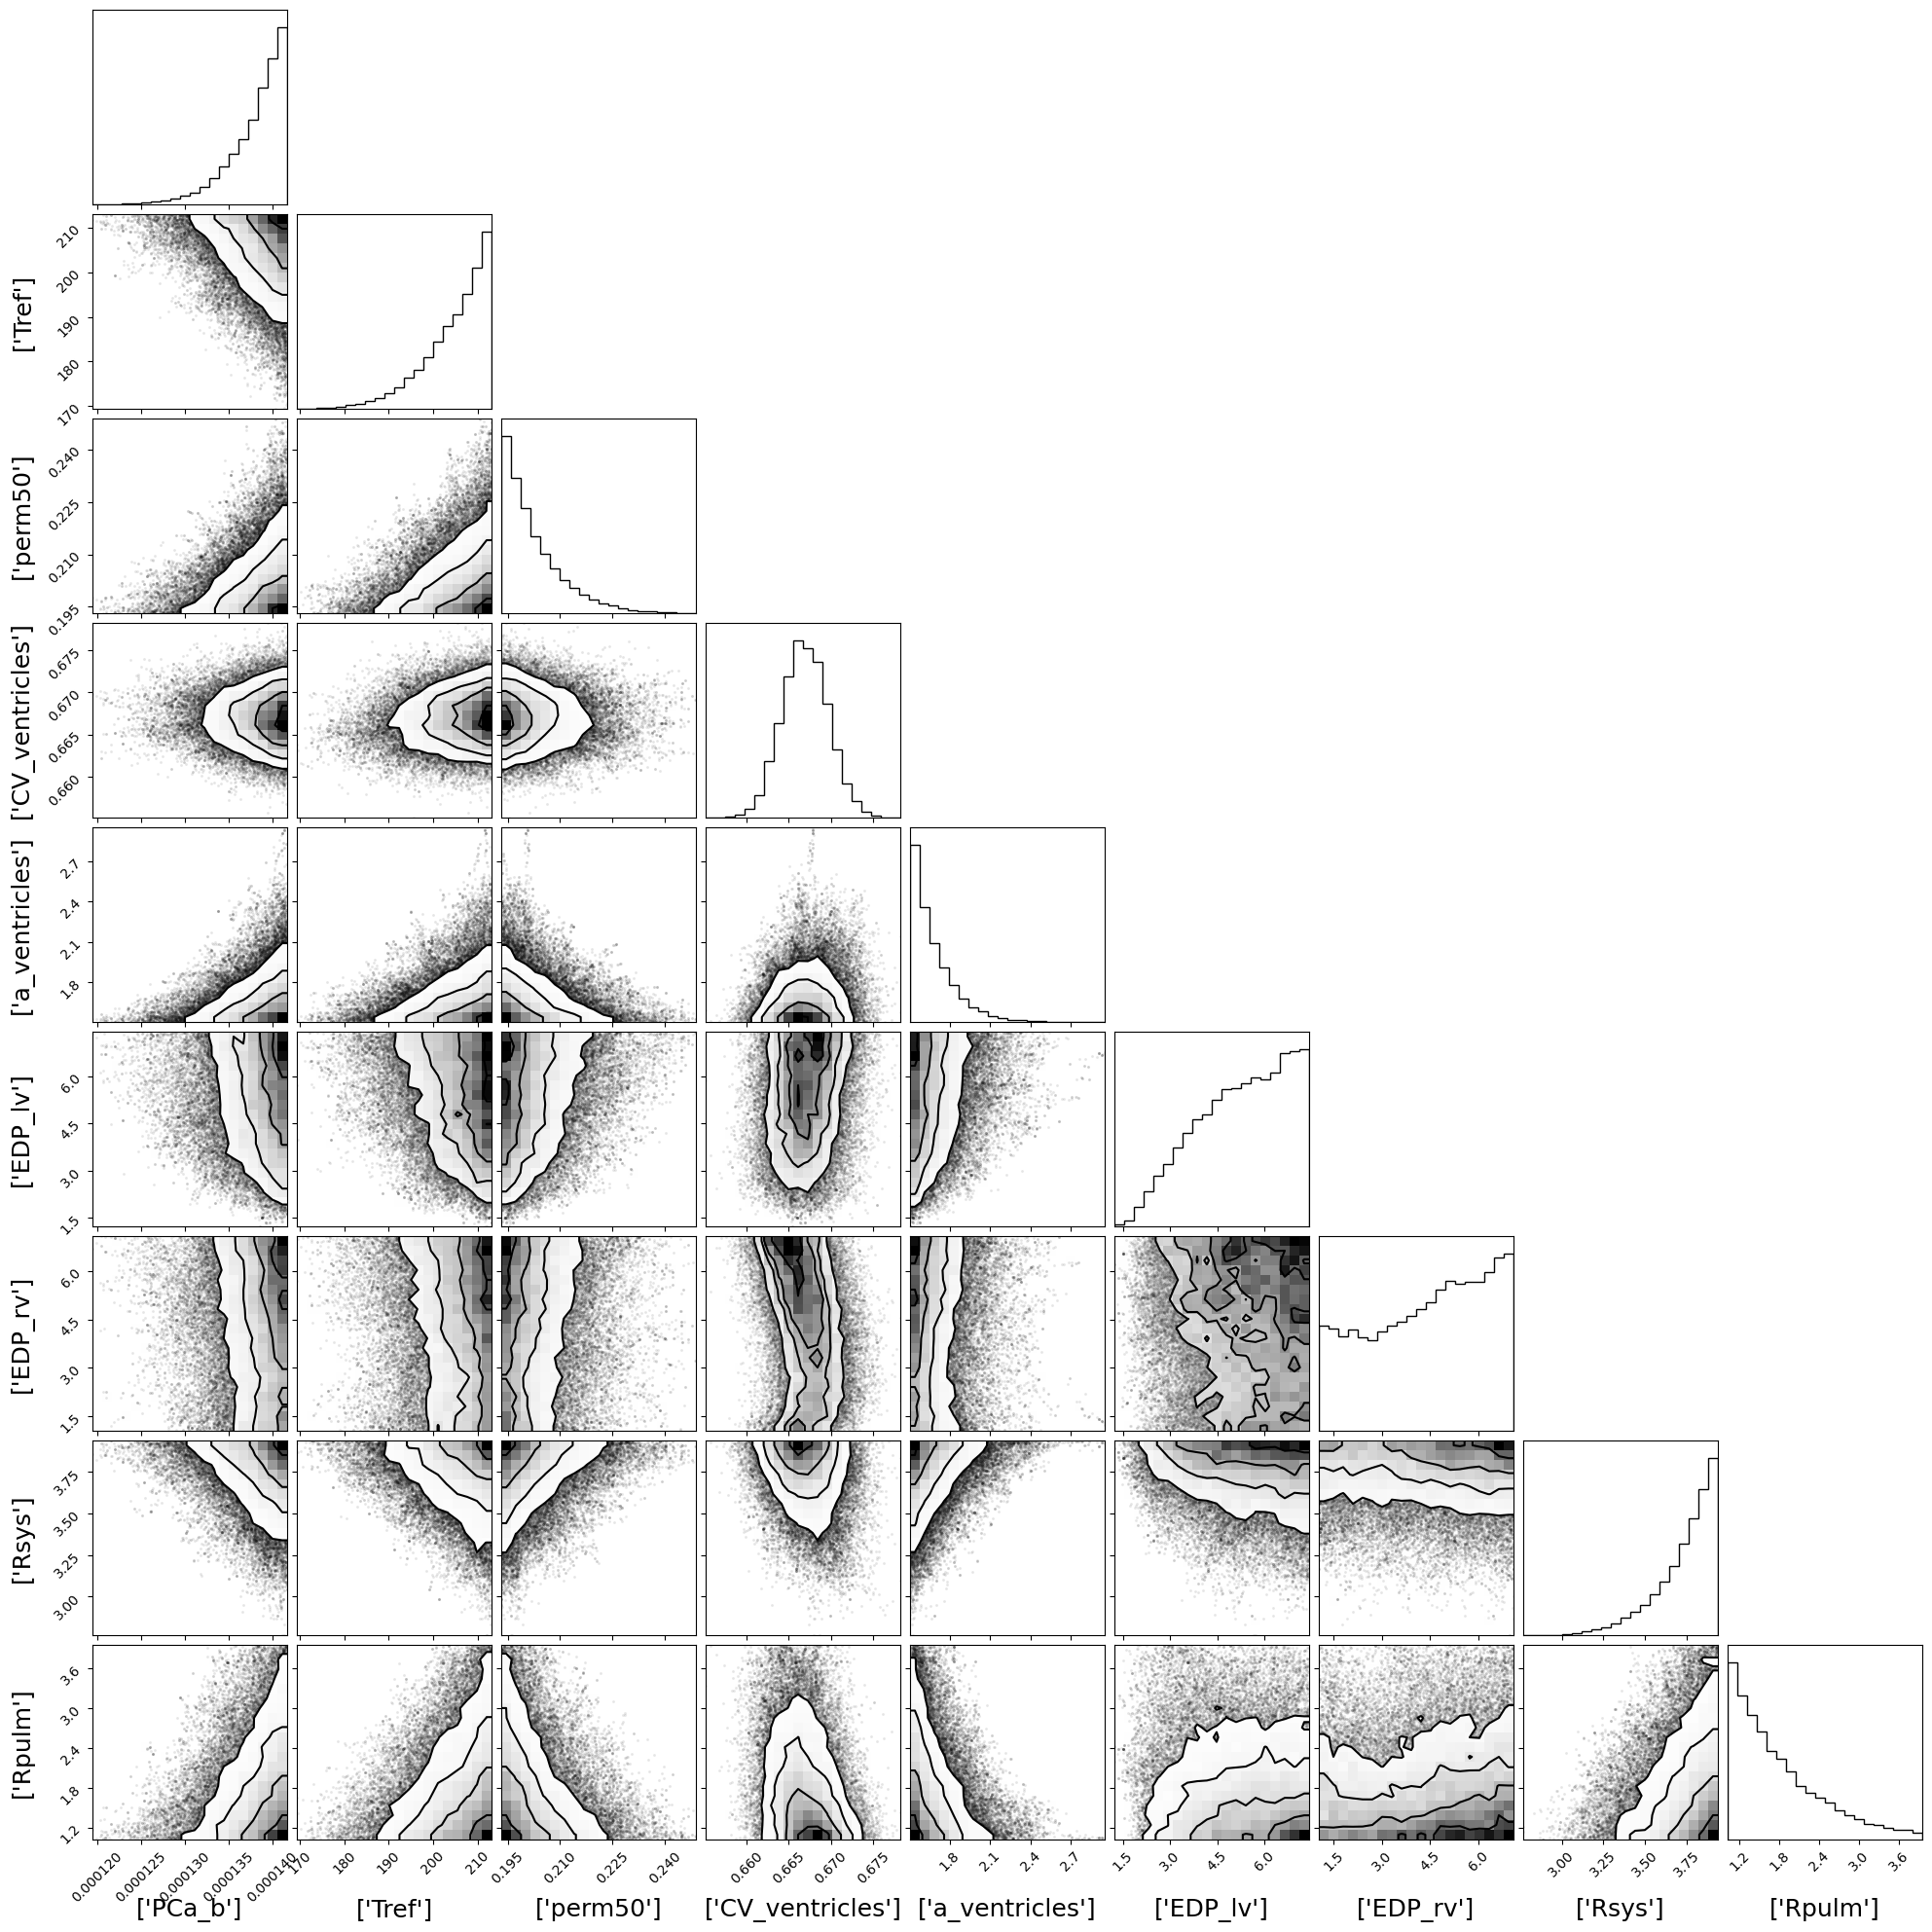

In [88]:
flat_samples = sampler.get_chain(discard=10000, thin=10, flat=True)
print(flat_samples.shape)

x_test

import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

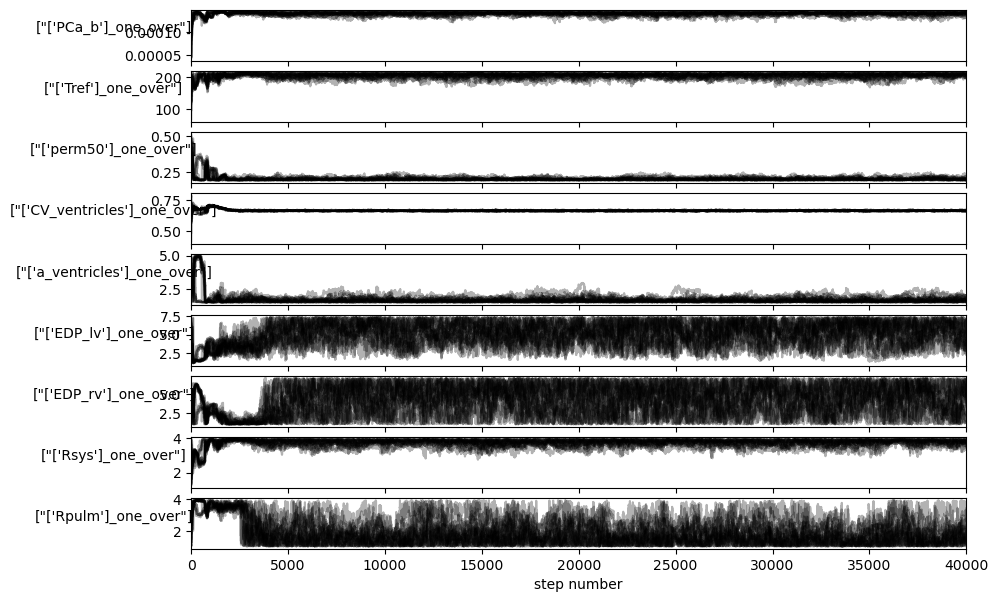

In [81]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [82]:
prediction=emulator.predict(torch.tensor(flat_samples)).detach().numpy()+lasso_model.predict(torch.cat([torch.tensor(flat_samples),torch.tensor(1/flat_samples)],axis=1))

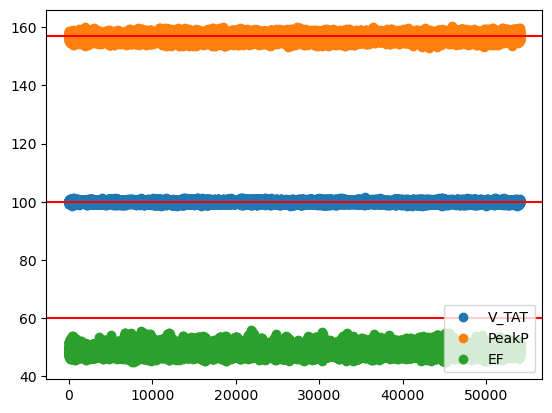

In [83]:
plt.plot(prediction[:,0:2],'o')
plt.plot(prediction[:,2]*100,'o')
plt.legend(('V_TAT','PeakP','EF'),loc='lower right')
plt.axhline(y=y_test[0], color='r', linestyle='-')
plt.axhline(y=y_test[1], color='r', linestyle='-')
plt.axhline(y=y_test[2]*100, color='r', linestyle='-')

In [85]:
x_labels

0
0          ['PCa_b']_one_over
1           ['Tref']_one_over
2         ['perm50']_one_over
3  ['CV_ventricles']_one_over
4   ['a_ventricles']_one_over
5         ['EDP_lv']_one_over
6         ['EDP_rv']_one_over
7           ['Rsys']_one_over
8          ['Rpulm']_one_over